## Sparse approximations

### Stochastic Variational Inference for scalability with SVGP

In [1]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
import torch
from src.utils import create_dataset, plot_matrix, plot_matrix_cv
from src.models.validation import measure_mnll, measure_rmse, sparsity_degree
from sklearn.model_selection import KFold
from src.models.kernels import LambdaRBF, ARD_gpflow 
from src.models.models import GPRLasso, SVGPLasso
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('pytorch ', torch.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 
tf.random.set_seed(42)
np.random.seed(42)

2023-04-15 19:32:54.944602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow  2.11.0
pytorch  1.13.1
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


In [2]:
X, Y = create_dataset('yacht', 0, False)
D = X.shape[1]
kfolds = KFold(n_splits = 3, shuffle=True, random_state=0)

In [13]:
def run_adam(model, train_dataset, minibatch_size, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

def kfold_cv_model(model=None, X=None, Y=None, prior=None, kernel=None, k_folds=None, model_params=None, iprint=False):
    if iprint:
        print('-- Model: %s; Kernel: %s; --'%(model, kernel))
    results = {'train_rmse': [], 
                'test_rmse': [], 
                'train_mnll': [], 
                'test_mnll': [], 
                'Lambda': [],
                'sparsity_degree': [],
                'avg_sparsity_degree': [],
                'avg_train_rmse': 0.,
                'avg_test_rmse': 0.,
                'avg_train_mnll': 0.,
                'avg_test_mnll': 0.,}
    D = X.shape[1]
    for _ , (train_index, test_index) in enumerate(k_folds.split(X)):
        # Define X_train, Y_train, X_test, Y_test for fold i
        X_train = X[train_index,:]
        X_test = X[test_index,:]
        Y_train = Y[train_index]
        Y_test = Y[test_index]
        Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
        Y_train = (Y_train - Y_train_mean) / Y_train_std
        Y_test = (Y_test - Y_train_mean) / Y_train_stds

        # Define the kernel: RBF(standard) or Lambda RBF
        if kernel == 'RBF-ARD':
            kernel = ARD_gpflow(variance=1.0, randomized=False, d=D)
        elif kernel == 'LRBF':
            kernel = LambdaRBF(variance=1.0, randomized=False, d=D)

        # Initialize the model: GPR or SVGP
        if model == 'GPR-Lasso':
            gp_model = GPRLasso(data=(X_train, Y_train), kernel=kernel, lasso=model_params['lasso'])
            gp_model.train()
        elif model == 'SVGP':
            num_inducing = model_params['num_inducing']
            lik = model_params['likelihood']
            Z = X_train[:num_inducing, :].copy()
            maxiter = model_params['max_iter']
            minibatch_size = model_params['minibatch_size']
            gp_model = gpflow.models.SVGP(kernel, lik, Z, num_data=num_inducing)
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(X_train.shape[0])
            logf = run_adam(gp_model, train_dataset, minibatch_size, maxiter)

        # Measure performances
        train_rmse_stan, test_rmse_stan = measure_rmse(gp_model, X_train, Y_train, X_test, Y_test)
        train_mnll, test_mnll = measure_mnll(gp_model, X_train, Y_train, Y_train_std, X_test, Y_test)
        results['train_rmse'].append(train_rmse_stan)
        results['test_rmse'].append(test_rmse_stan)
        results['train_mnll'].append(train_mnll)
        results['test_mnll'].append(test_mnll)
        results['Lambda'].append(gp_model.kernel.precision())
        results['sparsity_degree'].append(sparsity_degree(gp_model.kernel.precision(), tol=model_params['tol_sparsity']))


    results['avg_train_rmse'] = np.mean(results['train_rmse'])
    results['avg_test_rmse'] = np.mean(results['test_rmse'])
    results['avg_train_mnll'] = np.mean(results['train_mnll'])
    results['avg_test_mnll'] = np.mean(results['test_mnll'])
    results['avg_sparsity_degree'] = np.mean(results['sparsity_degree'])
    if iprint:
        print('Average test RMSE: %5.3f\nAverage test MNLL: %5.3f\n'%(results['avg_test_rmse'], results['avg_test_mnll']))
    return results
model_params = {'num_inducing': 10, 'likelihood': gpflow.likelihoods.Gaussian(), 'max_iter': 10000, 'minibatch_size': 1000, 'tol_sparsity': 0.1}
#results_RBF = kfold_cv_model(model='SVGP', kernel='RBF', k_folds=kfolds, model_params=model_params, iprint=True)
results_LRBF = kfold_cv_model(model='SVGP', kernel='LRBF', X=X, Y=Y, k_folds=kfolds, model_params=model_params, iprint=True)

-- Model: SVGP; Kernel: LRBF; --
Average test RMSE: 0.092
Average test MNLL: 1.656



name,class,transform,prior,trainable,shape,dtype,value
SVGPLasso.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGPLasso.kernel.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[2.44949, 2.44949, 2.44949..."
SVGPLasso.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGPLasso.inducing_variable.Z,Parameter,Identity,,True,"(100, 6)",float64,"[[0.05416, 0.16616, -0.03418..."
SVGPLasso.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[0....
SVGPLasso.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[1., 0., 0...."


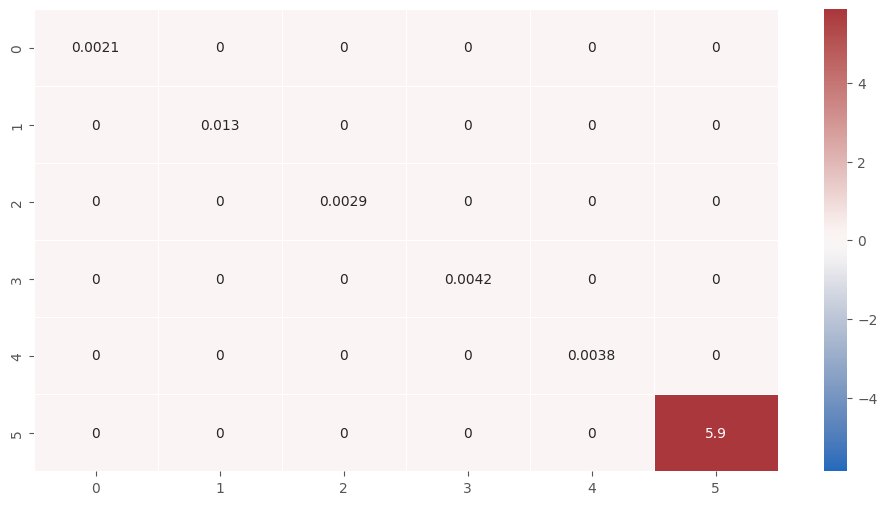

In [5]:
RBF = ARD_gpflow(variance=1.0, randomized=False, d=D)
svgp_lasso_RBF = SVGPLasso(data=(X, Y), kernel=RBF, lasso=0.1, num_inducing=100, likelihood=gpflow.likelihoods.Gaussian(), max_iter=10000, minibatch_size=100)
gpflow.utilities.print_summary(svgp_lasso_RBF, fmt="notebook")
svgp_lasso_RBF.train()
plot_matrix(svgp_lasso_RBF.kernel.precision())

name,class,transform,prior,trainable,shape,dtype,value
SVGPLasso.kernel.L,Parameter,Identity,,True,"(21,)",float64,"[0.40825, 0., 0...."
SVGPLasso.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGPLasso.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGPLasso.inducing_variable.Z,Parameter,Identity,,True,"(100, 6)",float64,"[[0.05416, 0.16616, -0.03418..."
SVGPLasso.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[0....
SVGPLasso.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[1., 0., 0...."


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


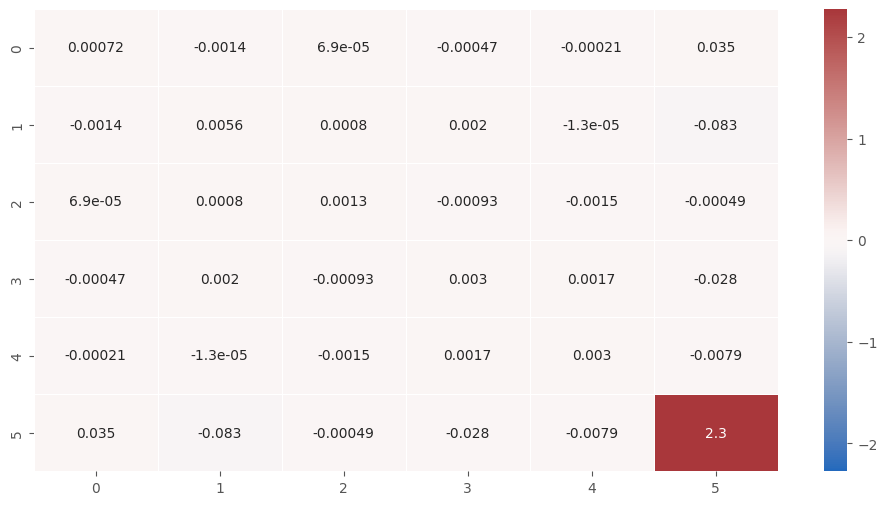

In [3]:
LRBF = LambdaRBF(variance=1.0, randomized=False, d=D)
svgp_lasso_LRBF = SVGPLasso(data=(X, Y), kernel=LRBF, lasso=10, num_inducing=100, likelihood=gpflow.likelihoods.Gaussian(), max_iter=10000, minibatch_size=100)
gpflow.utilities.print_summary(svgp_lasso_LRBF, fmt="notebook")
svgp_lasso_LRBF.train()
plot_matrix(svgp_lasso_LRBF.kernel.precision())

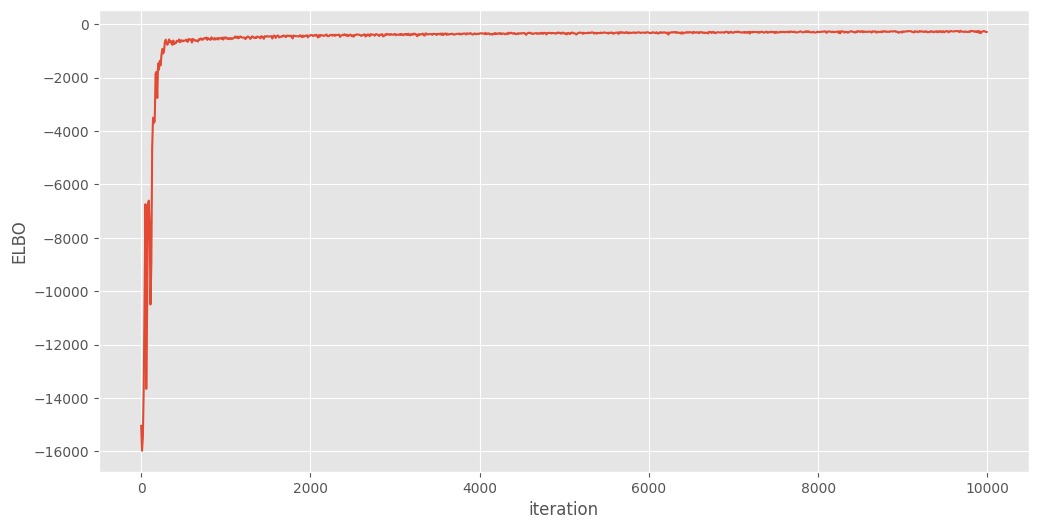

In [4]:
plt.plot(np.arange(10000)[::10], svgp_lasso_LRBF.logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")